In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import time

from auxfunctions import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

## Ejemplo N nearest neighbours

In [2]:
X = gen_observation_points(2, 10_000, 1)
x = np.array([[0.5,0.9]])

In [3]:
indexes = N_nearest_observations_points(X, x, 1_000)

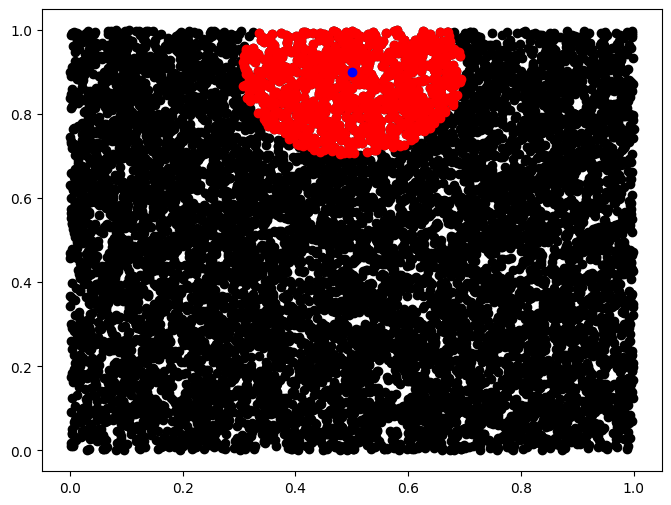

In [4]:
plt.figure(figsize=(8, 6))

plt.scatter(X[:,0], X[:,1], c='k')
plt.scatter(X[indexes,0], X[indexes,1], c='r')
plt.scatter(x[:,0], x[:,1], c='b');

## N vs RMSE, TIME

In [5]:
n_1 = 2_500
n_2 = 2_000
d = 2
sup = 20

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 1
theta_2 = 0.5

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)

In [6]:
X_1, X_2, Y_1, Y_2 = gen_observations(d, n_1, n_2, sup, nu_1, theta_1, nu_2, theta_2, nu_12, theta_12, rho_12)

In [7]:
X_1, X_test, Y_1, Y_test = train_test_split(X_1, Y_1, test_size=0.2)

Train set

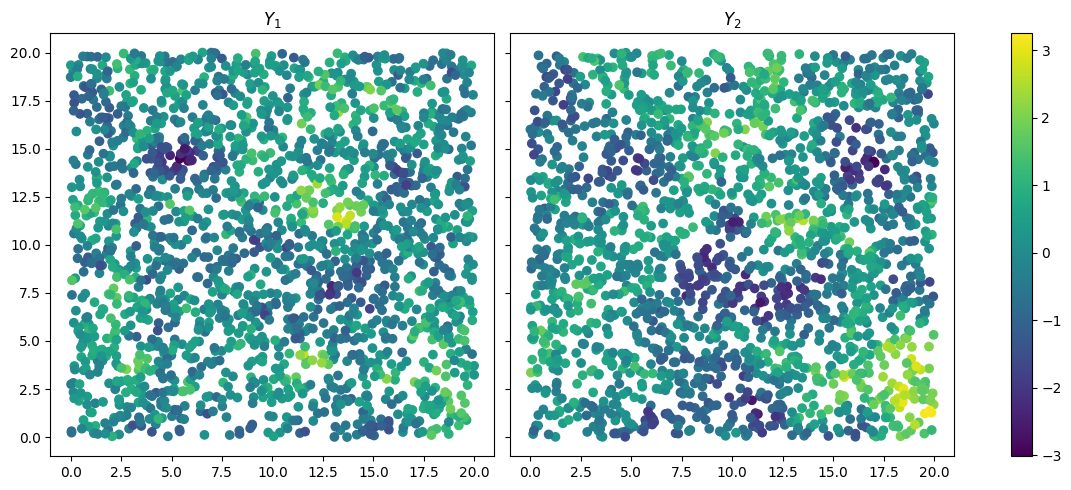

In [8]:
NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12).plot_obs()

In [10]:
times = []
rmses = []
Ns = np.arange(100, X_1.shape[0]+1, 100)
num_iterations = 1

for N in Ns:
    execution_time = 0
    rmse = 0
    for _ in range(num_iterations):
        start_time = time.time()
        
        coK_NN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, 
                             theta_1, theta_2, theta_12,
                             nu_1, nu_2, nu_12, rho_12)
        Y_pred = coK_NN.predict(X_test)
        
        end_time = time.time()
        
        execution_time += end_time - start_time
        rmse += root_mean_squared_error(Y_pred, Y_test)
    
    times.append(execution_time / num_iterations)
    rmses.append(rmse / num_iterations)

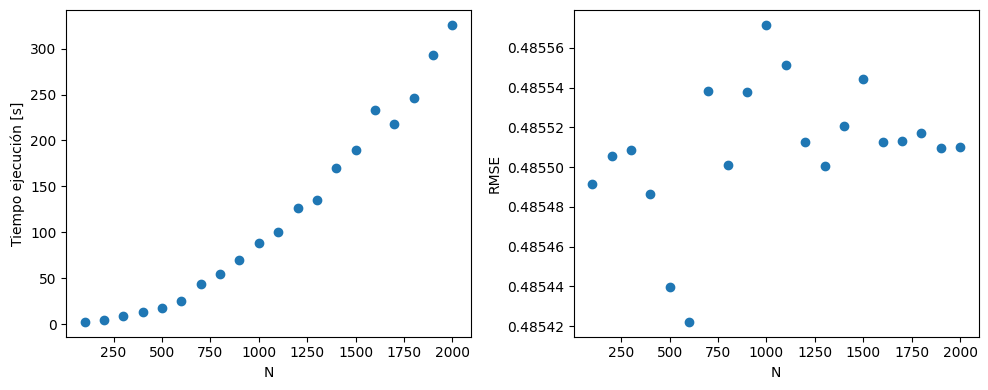

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.scatter(Ns, times)
ax1.set_xlabel('N'); ax1.set_ylabel('Tiempo ejecución [s]')

ax2.scatter(Ns, rmses)
ax2.set_xlabel('N'); ax2.set_ylabel('RMSE')

fig.tight_layout()

## CoKrigingNN vs NestedCoKriging

In [15]:
n_1 = 10_000 + 100
n_2 = 10_000
d = 2
sup = 20

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 1
theta_2 = 0.7

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)

In [16]:
X_1, X_2, Y_1, Y_2 = gen_observations(d, n_1, n_2, sup, nu_1, theta_1, nu_2, theta_2, nu_12, theta_12, rho_12)

In [17]:
X_test, Y_test = X_1[:100], Y_1[:100]
X_1, Y_1 = X_1[100:], Y_1[100:]

In [25]:
RMSEs_coKNN = []
RMSEs_NcoK = []
times_coKNN = []
times_NcoK = []

ns = [100, 500, 1_000, 2_000, 3_000, 5_000, 6_000, 8_000, 10_000]
num_iterations = 1

for n in ns:
    RMSE_coKNN = np.zeros(2)
    RMSE_NcoK = np.zeros(2)
    time_coKNN = np.zeros(2)
    time_NcoK = np.zeros(2)

    for _ in range(num_iterations):
        indices = np.random.choice(n_2, size=n, replace=False)
        X_1_aux, Y_1_aux = X_1[indices], Y_1[indices]
        X_2_aux, Y_2_aux = X_2[indices], Y_2[indices]

# NESTED CO KRIGING
        for i, n_clusters in enumerate([n//50, n//100]):
            start_time = time.time()
            A_1 = gen_A(X_1_aux, n_clusters)
            A_2 = gen_A(X_2_aux, n_clusters)
            NcoK = NestedCoKriging(X_1_aux, X_2_aux, Y_1_aux, Y_2_aux, theta_1, 
                                   theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
            Y_pred = NcoK.predict(X_test, A_1, A_2)
            end_time = time.time()
            
            time_NcoK[i] += (end_time - start_time)
            RMSE_NcoK[i] += root_mean_squared_error(Y_pred, Y_test)
        
# CO KRIGING NN
        for i, porcentaje in enumerate([10, 80]):    
            start_time = time.time()
            N = n * porcentaje // 100
            coKNN = coKrigingNN(X_1_aux, X_2_aux, Y_1_aux, Y_2_aux,
                                N, theta_1, theta_2, theta_12,
                                nu_1, nu_2, nu_12, rho_12)
            Y_pred = coKNN.predict(X_test)
            end_time = time.time()
            
            time_coKNN[i] += (end_time - start_time)
            RMSE_coKNN[i] += root_mean_squared_error(Y_pred, Y_test)

    RMSEs_NcoK.append(RMSE_NcoK / num_iterations)    
    RMSEs_coKNN.append(RMSE_coKNN / num_iterations)  
    
    times_NcoK.append(time_NcoK / num_iterations)    
    times_coKNN.append(time_coKNN / num_iterations)    

RMSEs_NcoK = np.array(RMSEs_NcoK)
RMSEs_coKNN = np.array(RMSEs_coKNN)
times_NcoK = np.array(times_NcoK)
times_coKNN = np.array(times_coKNN)

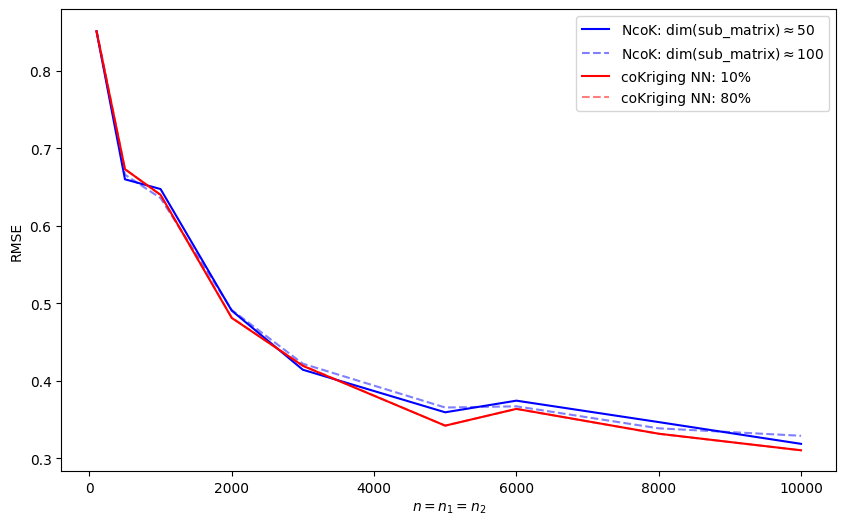

In [32]:
plt.figure(figsize=(10, 6))

plt.plot(ns, RMSEs_NcoK[:, 0], label=r'NcoK: dim(sub_matrix)$\approx$50', ls='-', c='b', alpha=1)
plt.plot(ns, RMSEs_NcoK[:, 1], label=r'NcoK: dim(sub_matrix)$\approx$100', ls='--', c='b', alpha=.5)
    
plt.plot(ns, RMSEs_coKNN[:, 0], label='coKriging NN: 10%', ls='-', c='r', alpha=1)
plt.plot(ns, RMSEs_coKNN[:, 1], label='coKriging NN: 80%', ls='--', c='r', alpha=.5)

plt.legend()
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('RMSE');

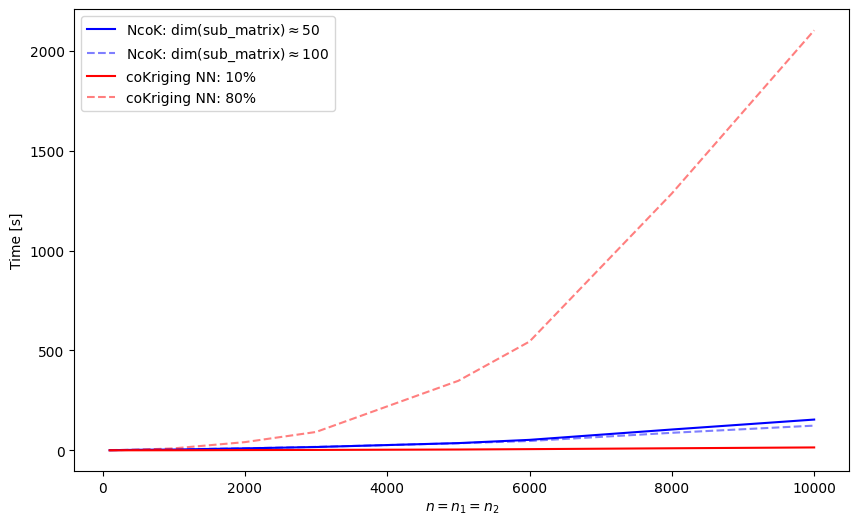

In [33]:
plt.figure(figsize=(10, 6))

plt.plot(ns, times_NcoK[:, 0], label=r'NcoK: dim(sub_matrix)$\approx$50', ls='-', c='b', alpha=1)
plt.plot(ns, times_NcoK[:, 1], label=r'NcoK: dim(sub_matrix)$\approx$100', ls='--', c='b', alpha=.5)
    
plt.plot(ns, times_coKNN[:, 0], label='coKriging NN: 10%', ls='-', c='r', alpha=1)
plt.plot(ns, times_coKNN[:, 1], label='coKriging NN: 80%', ls='--', c='r', alpha=.5)

plt.legend()
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('Time [s]');